#### To let the notebook properly run: define here below which is the target variable and download only the correct df; define target_def as the name of your target variable  

remember to set the right path for storing the graphs, or to reset pars for country_plot for not saving them 

In [1]:
%store -r data_merged
%store -r confirmed

dt_target=confirmed.copy()
target_def='confirmed'

# Packages and Basic information

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import Lasso
from sklearn.preprocessing import scale
from sklearn import metrics


In [4]:
import warnings
warnings.filterwarnings("ignore")

# Dataset creation

In [5]:
df=data_merged.merge(dt_target,right_index=True,left_index=True)
countries=df.country
dates=df.date
to_keep=df[target_def]

In [6]:
data=df.drop(['day','country_prov','ppl_km','urbanization','month','date','country','avg_age','pop20','confirmed',
              'active','deaths','recovered'],1)
data[target_def]=to_keep
print(data.shape)

(7900, 9)


In [7]:
data2=data.copy()
data2['date_code2']=df.date_code
data2['country_prov']=df.country_prov

In [8]:
data.head()

,date_code,country_code,confirmed_lag_1,confirmed_lag_2,confirmed_lag_3,confirmed_lag_4,confirmed_lag_5,confirmed_lag_6,confirmed
0,0,61,0,0,0,0,0,0,1
1,0,62,0,0,0,0,0,0,14
2,0,63,0,0,0,0,0,0,6
3,0,64,0,0,0,0,0,0,1
4,0,65,0,0,0,0,0,0,0


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7900 entries, 0 to 7925
Data columns (total 9 columns):
date_code          7900 non-null int64
country_code       7900 non-null int32
confirmed_lag_1    7900 non-null int64
confirmed_lag_2    7900 non-null int64
confirmed_lag_3    7900 non-null int64
confirmed_lag_4    7900 non-null int64
confirmed_lag_5    7900 non-null int64
confirmed_lag_6    7900 non-null int64
confirmed          7900 non-null int64
dtypes: int32(1), int64(8)
memory usage: 906.3 KB


# Preprocessing

#### log transform --optional

In [10]:
#def log_func(df,col):
#    df[col]=[np.log(x+1) for x in df[col].values]
#    return(df)

In [11]:
#cols=data.iloc[:,4:].columns
#for c in cols:
#    log_func(data,c)
#data.shape

#### scaling --useless

In [12]:
cols=data.columns
for c in cols:
    data[c]=scale(data[c])
data.shape

data['country_prov']=df.country_prov
data['date_code2']=df.date_code

# Functions

1. **calculate_lag**: it allows to create temporal lags and store them into the dataset as features
2. **split_date**: splits data in testset and trainset with explanatory and target variables based on date.<br> *additional features*: <br>
    a. if requested, returns just train and test
    b. verbosity
    c. setting the dates to be in specific ranges (day_lim_min,day_lim_max)
3. **all_regression**: aggregative function; it allows to obtain the predictions. it is based on a loop cycle to let the test to be recomputed at each cycle with the new predicted lags
4. **country_plot**: it lets to plot predictions and real values
5. **metrics_score**: fast way to develop main KPIs on the model

In [13]:
def calculate_lag(df, lag_list, column):
    for lag in lag_list:
        column_lag = column + "_lag_" + str(lag)
        df[column_lag] = df.groupby(['country_prov'])[column].shift(lag, fill_value=0)
    return df

In [14]:
#split data based on the day (especially date_code)
def split_date(day_lim,day_lim_max=-1,df=data,target=target_def,country='none', just_train=False):
    
    #utility to whether define country or not
    if country != 'none':
        df=df[df['country_prov']==country]
    else:
        pass
    
    train=df[df['date_code2']<day_lim]
    test=df[df['date_code2']>=day_lim]
    
    if just_train==True:
        return (train,test)
    else:
        train.drop(['country_prov'],1,inplace=True)
        test.drop(['country_prov'],1,inplace=True)

        X_train=train.drop([target],1)
        y_train=train[target]

        X_test=test.drop([target],1)
        y_test=test[target]
        if day_lim_max!=-1:
            X_test=X_test[X_test['date_code2']<=day_lim_max]
        
        X_test.drop('date_code2',1,inplace=True)
        X_train.drop('date_code2',1,inplace=True)
        
        print('train and test shape:',X_train.shape,X_test.shape)
        
        return (X_train,y_train,X_test,y_test)

In [15]:
def all_regression(a,fi,p,rs,day_start,end=60,df_standardized=data,df=data2, target=target_def,lags=7):
    
    df2=df_standardized.copy()   
    df3=df.copy()
    
    #setting parameters
    X_train,y_train,X_test,y_test = split_date(df=df3,day_lim=day_start,target=target)
    regr = Lasso(alpha=a,fit_intercept=fi,positive=p,random_state=rs)
    regr.fit(X_train, y_train)
    
    # prediction for each day, iteratively
    for d in list(range(day_start,end+1)):
        print('day:',d)
        
        #1. split train and test
        X_train,y_train,X_test,y_test = split_date(df=df3,day_lim=day_start,day_lim_max=d,target=target)
        
        #2. predict through Ridge and cleaning insensated data
        pred = pd.Series(regr.predict(X_test))
        pred= pred.values
        pred[pred<0]=0
        pred= np.around(pred)

        #3. save predictions as new confirmed case
        idx=df3.loc[df.date_code>=day_start].index.values
        idx=idx[:len(pred)]
        for j,i in list(zip(idx,pred)):
            df3.loc[j,target]=i
        
        #4. recompute lags for df copied
        df3 = calculate_lag(df3, range(1,lags), target)
        
    #df2 returned must be then split in train and test, the new test will be the finite one
    train,test=split_date(df=df3,day_lim=day_start,just_train=True)
    #test=test['confirmed']
    return train,test



In [16]:
from datetime import datetime
import matplotlib.dates as mdates
def country_plot(df,title='ABC',x_size=20,y_size=6,split='2020-03-16',save_fig=False,path=''):
    s= datetime.strptime(split, '%Y-%m-%d')
    plt.figure(figsize=(x_size,y_size))

    x_values = df['date']
    y_values=df['real']
    z_values=df['prediction']

    plt.plot(x_values,z_values, 'g-',label='predictions')
    plt.plot(x_values,y_values, 'r-', label='real')
    plt.axvline(s, linestyle='--')
    plt.title(title)
    plt.legend()
    plt.xticks(rotation=45)
    if save_fig==True:
        plt.savefig(path+title+'-lasso.png')
    return(plt.show())

In [17]:
def metrics_score(model,X_train,y_train,X_test,y_test):
    print('********************************** Testset *********************************')
    print('')
    print("MAE test: ", metrics.mean_absolute_error(y_test, model.predict(X_test))) 
    print("MSE test: ",metrics.mean_squared_error(y_test, model.predict(X_test)))
    print("RMSE test: ",np.sqrt(metrics.mean_squared_error(y_test, model.predict(X_test))))
    print("r2: ",np.sqrt(metrics.r2_score(y_test, model.predict(X_test))))

------------------------------------

# Predictions

In [18]:
print(data.date_code2.max(),data.date_code2.min())

60 0


## Confirmed 

#### define the day of start for reasearch

In [19]:
day=55

#### searching for best Ridge pars 

In [20]:
X_train,y_train,X_test,y_test = split_date(df=data2,day_lim=day,target=target_def)

train and test shape: (6154, 8) (1746, 8)


In [21]:
reg=Lasso()
pars={'alpha':[0.001,0.01,0.1,1,10,100],
     'fit_intercept':[True,False],
     'positive':[True,False],
     'random_state':[123]}

In [22]:
gs = GridSearchCV(reg,pars, cv=4)
gs.fit(X_train,y_train)

GridSearchCV(cv=4, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
                         'fit_intercept': [True, False],
                         'positive': [True, False], 'random_state': [123]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [23]:
print("Best score: %f using %s" % (gs.best_score_, gs.best_params_)) 
pars=gs.best_params_
a_best,fi_best,p_best,rs_best=pars['alpha'],pars['fit_intercept'],pars['positive'],pars['random_state']

Best score: 0.995038 using {'alpha': 100, 'fit_intercept': False, 'positive': False, 'random_state': 123}


In [24]:
print('Intercept: ', gs.best_estimator_.intercept_)

columns=X_train.columns
pd.DataFrame(list(zip(columns,gs.best_estimator_.coef_)), columns = ['features','estimatedCoefficients'])

Intercept:  0.0


,features,estimatedCoefficients
0,date_code,0.126100
1,country_code,0.011614
2,confirmed_lag_1,1.284119
3,confirmed_lag_2,-0.123218
4,confirmed_lag_3,0.012293
5,confirmed_lag_4,-0.023637
6,confirmed_lag_5,-0.038317
7,confirmed_lag_6,-0.112273


####  predict

In [25]:
train,predictions=all_regression(a=a_best,fi=fi_best,p=p_best,rs=rs_best,day_start=day)

train and test shape: (6154, 8) (1746, 8)
day: 55
train and test shape: (6154, 8) (273, 8)
day: 56
train and test shape: (6154, 8) (554, 8)
day: 57
train and test shape: (6154, 8) (843, 8)
day: 58
train and test shape: (6154, 8) (1139, 8)
day: 59
train and test shape: (6154, 8) (1440, 8)
day: 60
train and test shape: (6154, 8) (1746, 8)


#### evaluate

In [26]:
X_test=predictions.drop(['country_prov',target_def,'date_code2'],1)

In [27]:
y_test_pred=predictions[target_def]

In [28]:
print("Score on Train:", gs.score(X_train, y_train))
print("Score on test:", gs.score(X_test, y_test))
print('')
print('********************************* Trainset *********************************')
print('')
print("MAE train: ", metrics.mean_absolute_error(y_train, gs.predict(X_train))) 
print("MSE train: ",metrics.mean_squared_error(y_train, gs.predict(X_train)))
print("RMSE train: ",np.sqrt(metrics.mean_squared_error(y_train, gs.predict(X_train))))
print("r2: ",np.sqrt(metrics.r2_score(y_train, gs.predict(X_train))))
print('')
print('********************************** Testset *********************************')
print('')
print("MAE test: ", metrics.mean_absolute_error(y_test,y_test_pred )) 
print("MSE test: ",metrics.mean_squared_error(y_test,y_test_pred ))
print("RMSE test: ",np.sqrt(metrics.mean_squared_error(y_test,y_test_pred )))
print("r2: ",np.sqrt(metrics.r2_score(y_test,y_test_pred )))

Score on Train: 0.9980302630043819
Score on test: 0.9696530046462879

********************************* Trainset *********************************

MAE train:  22.677015435116846
MSE train:  47515.05616565512
RMSE train:  217.9794856532493
r2:  0.9990146460409787

********************************** Testset *********************************

MAE test:  158.58991981672395
MSE test:  830783.6128293242
RMSE test:  911.4733198669746
r2:  0.9847103388357517


#### prepare dataset to plot

In [29]:
pred_test=pd.concat([train,predictions],0)
pred_test['country']=countries
pred_test['date']=dates
pred_test['real']=data2[target_def]

pred_test=pred_test[['date','country','country_prov','real',target_def]]
pred_test.columns=['date','country','country_prov','real','prediction']

pred_test.tail(100)

,date,country,country_prov,real,prediction
7823,2020-03-22,US,US_Alaska,21,107.0
7824,2020-03-22,US,US_South Dakota,21,135.0
7825,2020-03-22,Macao,Macao_Macao,20,106.0
7826,2020-03-22,Australia,Australia_Australian Capital Territory,19,76.0
7827,2020-03-22,Canada,Canada_Manitoba,19,94.0
...,...,...,...,...,...
7919,2020-03-22,Guam,Guam_,0,98.0
7922,2020-03-22,Puerto Rico,Puerto Rico_,0,108.0
7923,2020-03-22,DR Congo,DR Congo_,0,34.0
7924,2020-03-22,Bahamas,Bahamas_,0,5.0


In [30]:
# in this case it is possible to plot by country in an aggregate form
df_countrymax=pred_test.groupby(['date','country']).sum()
df_countrymax.reset_index(inplace=True)
print(df_countrymax.shape)

(3893, 4)


In [33]:
#country_name=df_countrymax.country.unique()
country_name=['Malaysia','DR Congo','Italy','China']
print(len(country_name))

4


#### plot results

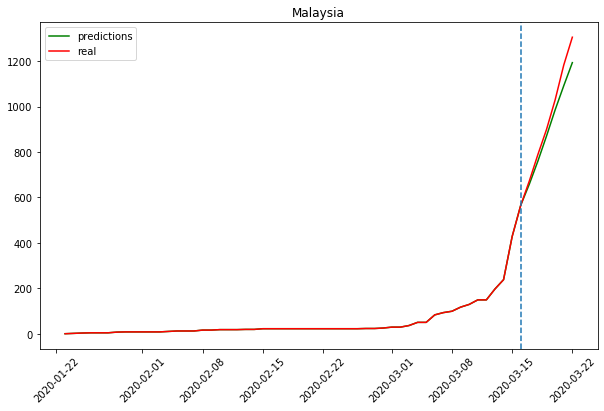

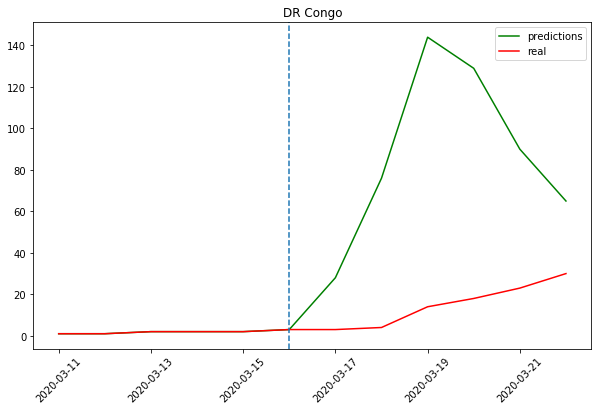

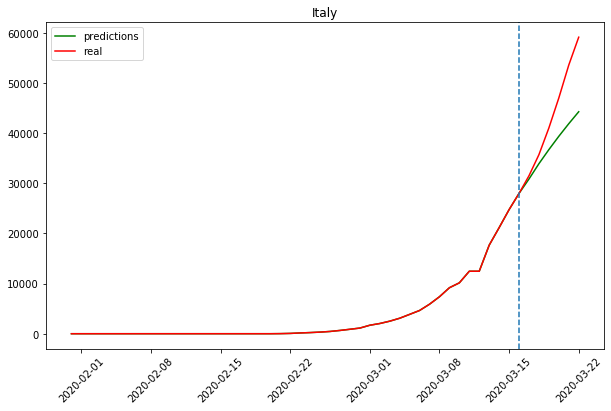

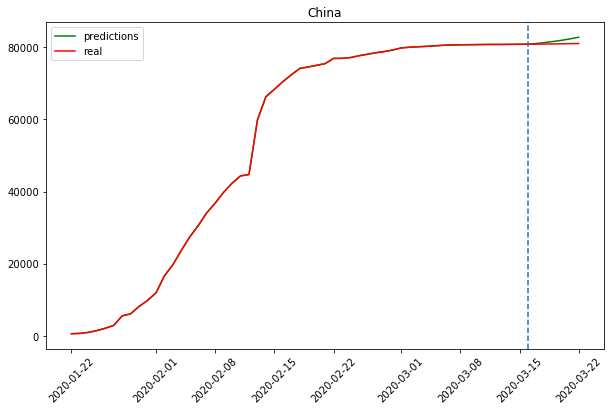

In [34]:
for name in country_name:
    dt=df_countrymax[df_countrymax['country']==name]
    country_plot(dt,name,x_size=10,y_size=6)